<a href="https://colab.research.google.com/github/Vahid-GitHub/Optimization/blob/master/04_optimization_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# using optimizers in pytorch

In [2]:
# libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
import copy
# device, gpu or cpu
dvc = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device is', dvc)

device is cuda


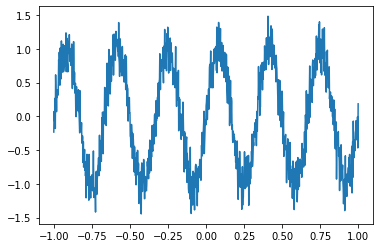

In [3]:
# make the one dimensional function
# making the function
dt = torch.float32
pi = torch.acos(torch.Tensor([-1])).to(dvc)
ns = 1000
freq = 3
mu, std = 0, 0.2
t = torch.linspace(-1, 1, ns, dtype=dt).reshape((ns, 1)).to(dvc)
fun1 = torch.sin(2*pi*freq*t).to(dvc) + torch.randn((ns, 1), device=dvc) * std + mu
plt.plot(t.detach().cpu(), fun1.detach().cpu())

For 5 dimmensions ==> MSE: 0.5273


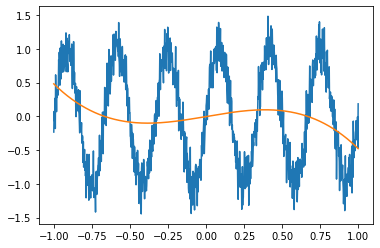

In [4]:
# least mean square estimation with extended features

# # add bias
# t_bias = torch.cat((torch.ones((t.shape[0], 1), device=device), t), dim=1)
# print(t_bias[:10, :])
# # add bias and sin
# t_extended = torch.cat((torch.ones((t.shape[0], 1), device=device), t, torch.sin(2*pi*0.5*t)), dim=1)

# # add bias and x^2
# t_extended = torch.cat((torch.ones((t.shape[0], 1), device=device), t, t**2), dim=1)

# add bias and higher orders polynomials
t_ext = torch.ones((t.shape[0], 1), device=dvc, requires_grad=True)
for order in range(1, 5, 1):
    t_ext = torch.cat((t_ext, t**order), dim=1)

# # add bias and higher orders geometrical functions
# t_extended = torch.ones((t.shape[0], 1), device=device, dtype=data_type)
# t_extended = torch.cat((t_extended, t), dim=1)
# for order in range(1, 45):
#     t_extended = torch.cat((t_extended, torch.sin(order*t), torch.cos(order*t)), dim=1)

# # add bias and higher orders tanh functions
# t_extended = torch.ones((t.shape[0], 1), device=device, dtype=data_type)
# t_extended = torch.cat((t_extended, t), dim=1)
# for order in range(1, 20, 3):
#     t_extended = torch.cat((t_extended, torch.tanh(order*t)), dim=1)

# # add bias and higher orders sigmoid functions
# t_extended = torch.ones((t.shape[0], 1), device=device, dtype=data_type)
# t_extended = torch.cat((t_extended, t), dim=1)
# for order in range(1, 20):
#     t_extended = torch.cat((t_extended, torch.sigmoid(order*t)), dim=1)

# # add bias and higher orders functions
# t_extended = torch.ones((t.shape[0], 1), device=device, dtype=data_type)
# t_extended = torch.cat((t_extended, t), dim=1)
# for order in range(1, 50, 5):
#     t_extended = torch.cat((t_extended, torch.nn.functional.softsign(order*t)), dim=1)


# optimize with lstsq
X, QR = torch.lstsq(fun1, t_ext)
# just the first 2 elements of the output is the answer and all others are residuals.
line = t_ext.mm(X[0:t_ext.shape[1]])
print(f'For {t_ext.shape[1]} dimmensions ==> MSE: {torch.nn.functional.mse_loss(line, fun1).item():.4f}')
plt.figure()
plt.plot(t.detach().cpu(), fun1.detach().cpu())
plt.plot(t.detach().cpu(), line.detach().cpu())

MSE: 0.49873843789100647


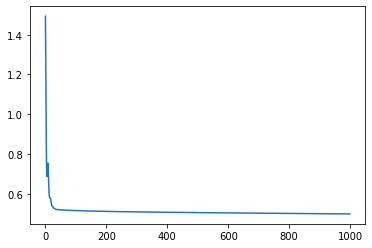

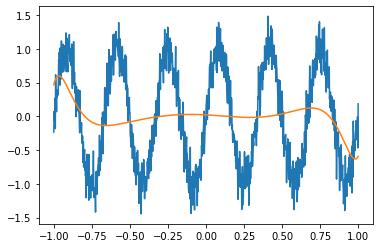

In [5]:
# optimize with SGD with extended features

order = 20
loss_fn = torch.nn.MSELoss()
b = torch.randn(order, device=dvc).requires_grad_(True)

# polynomial model
def mdl(x, a=b):
  y = torch.zeros(x.size(), device=dvc)
  for d, c in enumerate(b):
    y += c * x ** d
  return y

# # tanh model
# def mdl(x, a=b):
#   y = torch.zeros(x.size())
#   for c in b:
#     y += torch.tanh(c*x)
#   return y

# # geometrical model
# def mdl(x, a=b):
#   y = torch.zeros(x.size())
#   for d, c in enumerate(b):
#     y += c * torch.sin(d*x)
#   return y

optimizer = torch.optim.SGD([b], lr=0.05, momentum=0.8)
# optimizer = torch.optim.Adam([b], lr=0.01)

all_loss = []
all_bs = []
# for x, y in zip(t, fun1):
for _ in range(1000):
  optimizer.zero_grad()
  yp = mdl(t, b)
  loss = loss_fn(yp, fun1)
  loss.backward()
  optimizer.step()
  all_loss.append(loss.item())
  all_bs.append(b)

print(f'MSE: {loss.item()}')
plt.figure(); plt.plot(all_loss)
# plt.figure(); plt.plot(all_bs)
plt.figure()
plt.plot(t.detach().cpu(), fun1.detach().cpu())
plt.plot(t.detach().cpu(), mdl(t, b).detach().cpu())

MSE: 0.3956


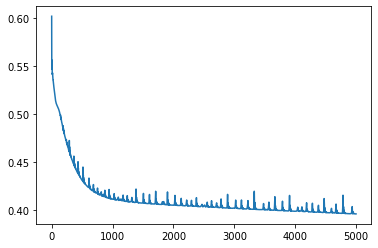

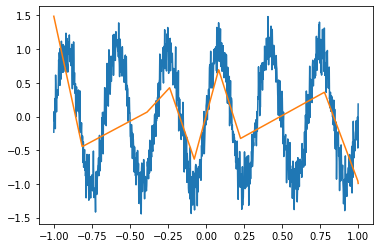

In [6]:
# optimize with SGD on network without extended features
order = 1
hidden = 20

loss_fn = torch.nn.MSELoss()
# mdl = torch.nn.Sequential(torch.nn.Linear(order, hidden),
#                           torch.nn.Sigmoid(),
#                           torch.nn.Linear(hidden, 1))
class model(torch.nn.Module):
  def __init__(self):
    super(model, self).__init__()
    self.L1 = torch.nn.Linear(order, hidden)
    self.L2 = torch.nn.Linear(hidden, 1)
  def forward(self, x):
    x = self.L1(x)
    x = torch.relu(x)
    # x = torch.sin(x)
    x = self.L2(x)
    return(x)
mdl = model()
mdl.to(dvc)

# optimizer = torch.optim.SGD(mdl.parameters(), lr=0.01, momentum=0.95)
optimizer = torch.optim.Adam(mdl.parameters(), lr=0.03)

all_loss = []
best_mdl = None
min_loss = np.inf
# for x, y in zip(t, fun1):
for _ in range(5000):
  optimizer.zero_grad()
  yp = mdl(t)
  loss = loss_fn(yp, fun1)
  loss.backward()
  optimizer.step()
  all_loss.append(loss.item())
  if loss.item() < min_loss:
    min_loss = loss.item()
    best_mdl = copy.deepcopy(mdl)

print(f'MSE: {min_loss:.4f}')
plt.figure(); plt.plot(all_loss)
# plt.figure(); plt.plot(all_bs)
plt.figure()
plt.plot(t.detach().cpu(), fun1.detach().cpu())
plt.plot(t.detach().cpu(), best_mdl(t).detach().cpu())

MSE: 0.0376


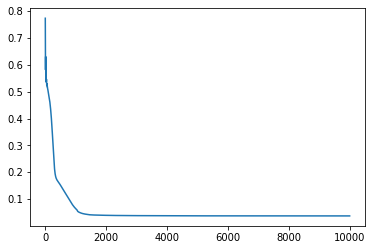

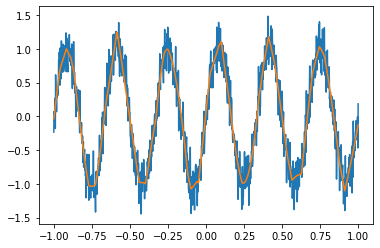

In [7]:
# optimize with SGD on network with extended features
order = 7
hidden = 20

# # add bias and higher orders polynomials
# t_ext = torch.ones((t.shape[0], 1), device=dvc, requires_grad=True)
# for ord in range(1, order, 1):
#     t_ext = torch.cat((t_ext, t**ord), dim=1)

# add bias and higher orders geometrical functions
t_ext = torch.ones((t.shape[0], 1), device=dvc, dtype=dt)
t_ext = torch.cat((t_ext, t), dim=1)
for order in range(1, order):
    t_ext = torch.cat((t_ext, torch.sin(order*t)), dim=1)

loss_fn = torch.nn.MSELoss()
# mdl = torch.nn.Sequential(torch.nn.Linear(order, hidden),
#                           torch.nn.Sigmoid(),
#                           torch.nn.Linear(hidden, 1))
class model(torch.nn.Module):
  def __init__(self):
    super(model, self).__init__()
    self.L1 = torch.nn.Linear(t_ext.shape[1], hidden)
    self.L2 = torch.nn.Linear(hidden, 1)
  def forward(self, x):
    x = self.L1(x)
    x = torch.relu(x)
    # x = torch.sin(x)
    x = self.L2(x)
    return(x)
mdl = model()
mdl.to(dvc)

optimizer = torch.optim.SGD(mdl.parameters(), lr=0.01, momentum=0.95)
# optimizer = torch.optim.Adam(mdl.parameters(), lr=0.07)

all_loss = []
best_mdl = None
min_loss = np.inf
# for x, y in zip(t, fun1):
for _ in range(10000):
  optimizer.zero_grad()
  yp = mdl(t_ext)
  loss = loss_fn(yp, fun1)
  loss.backward()
  optimizer.step()
  all_loss.append(loss.item())
  if loss.item() < min_loss:
    min_loss = loss.item()
    best_mdl = copy.deepcopy(mdl)

print(f'MSE: {min_loss:.4f}')
plt.figure(); plt.plot(all_loss)
# plt.figure(); plt.plot(all_bs)
plt.figure()
plt.plot(t.detach().cpu(), fun1.detach().cpu())
plt.plot(t.detach().cpu(), best_mdl(t_ext).detach().cpu())

MSE: 0.0413


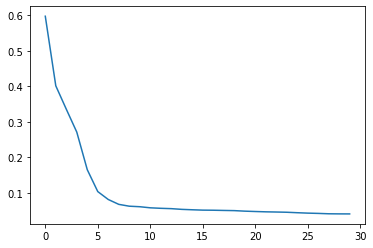

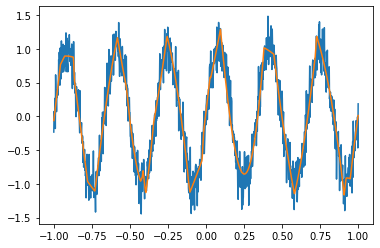

In [8]:
# optimize with LBFGS on network with extended features and 
order = 5
hidden = 20

# # add bias and higher orders polynomials
# t_ext = torch.ones((t.shape[0], 1), device=dvc, requires_grad=True)
# for ord in range(1, order, 1):
#     t_ext = torch.cat((t_ext, t**ord), dim=1)

# add bias and higher orders geometrical functions
t_ext = torch.ones((t.shape[0], 1), device=dvc, dtype=dt)
t_ext = torch.cat((t_ext, t), dim=1)
for order in range(1, order):
    t_ext = torch.cat((t_ext, torch.sin(order*t)), dim=1)

loss_fn = torch.nn.MSELoss()
# mdl = torch.nn.Sequential(torch.nn.Linear(order, hidden),
#                           torch.nn.Sigmoid(),
#                           torch.nn.Linear(hidden, 1))
class model(torch.nn.Module):
  def __init__(self):
    super(model, self).__init__()
    self.L1 = torch.nn.Linear(t_ext.shape[1], hidden)
    self.L2 = torch.nn.Linear(hidden, 1)
  def forward(self, x):
    x = self.L1(x)
    x = torch.relu(x)
    # x = torch.sin(x)
    x = self.L2(x)
    return(x)
mdl = model()
mdl.to(dvc)

# optimizer = torch.optim.SGD(mdl.parameters(), lr=0.01, momentum=0.95)
# optimizer = torch.optim.Adam(mdl.parameters(), lr=0.07)
optimizer = torch.optim.LBFGS(mdl.parameters(), lr=1, max_iter=20)

all_loss = []
best_mdl = None
min_loss = np.inf

def closure():
    optimizer.zero_grad()
    yp = mdl(t_ext)
    loss = loss_fn(yp, fun1)
    loss.backward()
    return loss
for _ in range(30):
  loss = optimizer.step(closure)
  all_loss.append(loss.item())
  if loss.item() < min_loss:
    min_loss = loss.item()
    best_mdl = copy.deepcopy(mdl)

print(f'MSE: {min_loss:.4f}')
plt.figure(); plt.plot(all_loss)
# plt.figure(); plt.plot(all_bs)
plt.figure()
plt.plot(t.detach().cpu(), fun1.detach().cpu())
plt.plot(t.detach().cpu(), best_mdl(t_ext).detach().cpu())